In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from owi_data_2_pandas.io import API
import datetime
from pytz import utc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Import vub Meetenet Vlaamse Banken API functions
from vubmvbc.config import Credentials
from vubmvbc.client import Base
from vubmvbc.objects import Catalog, Data
import vubmvbc.data_getter as dg

from oma_tracking.oma_clustering import ModeClusterer  #pip install hdbscan --no-build-isolation --no-binary :all
from oma_tracking.data.make_dataset import DatasetGetter, get_scada_subset, get_weather_subset
from oma_tracking.data.utils import get_rated_data, get_parked_data, read_simulations_csv_files
from oma_tracking.scouring.scouring import aggregate_time_series

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


First run the mode_tracking notebook for this location!

In [5]:
start =  datetime.datetime(2022,11,1,tzinfo=utc)
stop  = datetime.datetime(2023,3,1,tzinfo=utc)
location = 'nw2d01'
name_location = 'NW2_D01'

home_folder = "../../../"
# Data Paths
data_file_name = '_'.join([location, start.strftime("%Y%m%d"), stop.strftime("%Y%m%d")])
data_path = home_folder + "data/nw2/raw/" + data_file_name + ".parquet"
mvbc_path = home_folder + "data/nw2/mvbc_data.parquet"
tracked_frequencies_path = home_folder + "data/nw2/tracked_modes/harmonics_removed/" + location + ".parquet"
simulations_data_path = home_folder + "data/nw2/simulations/" + location + "/"
simulations_data_path


# Get all the data
data = pd.read_parquet(data_path)
mvbc_data = pd.read_parquet(mvbc_path)
tracked_frequencies = pd.read_parquet(tracked_frequencies_path)
simulation_data = read_simulations_csv_files(simulations_data_path + "eigen_frequencies/")
simulation_shifts = read_simulations_csv_files(simulations_data_path + "mean_shifts/")
simulation_errors = pd.read_csv(simulations_data_path + "errors/Errors_No_scour.csv", index_col=0)

In [6]:
# Data Transformation
mode_simulation_data = {
    'SS1': pd.DataFrame(),
    'FA1': pd.DataFrame(),
    'SS2': pd.DataFrame(),
    'FA2': pd.DataFrame(),
}
for key in simulation_data.keys():
    if 'Eigen_' in key:
        simulation_data[key].rename(
            columns={
                '1st SS': 'SS1',
                '1st FA': 'FA1',
                '2nd SS': 'SS2',
                '2nd FA': 'FA2',
            }, inplace=True
        )
        for mode in ['SS1', 'FA1', 'SS2', 'FA2']:
            mode_simulation_data[mode][key] = simulation_data[key][mode]

# order the columns
cols = list(simulation_data.keys())
ordered_cols = [cols[0]] + cols[9:11] + cols[1:9] + [cols[11]] + cols[20:22] + cols[12:20]
for mode in ['SS1', 'FA1', 'SS2', 'FA2']:
    mode_simulation_data[mode] = mode_simulation_data[mode][ordered_cols]
    mode_simulation_data[mode].to_csv(simulations_data_path + "mode_frequencies/" + mode + ".csv")

tracked_modes = \
    tracked_frequencies.rename(
        columns = {
            'FA1': '1st FA',
            'FA2': '2nd FA',
            'SS1': '1st SS',
            'SS2': '2nd SS',
        }
    )

In [7]:
import mlflow
models = {}
for mode in tracked_frequencies.columns:
    model_name = 'mpe_' + name_location + '_' + mode + '_normalization'
    stage = 'Staging'
    try:
        models[mode] = \
            mlflow.pyfunc.load_model(
                model_uri=f"models:/{model_name}/{stage}")
    except:
        print('no ' + stage + ' model ' + model_name)

In [8]:
weather_inputs = get_weather_subset(mvbc_data)
scada_inputs = get_scada_subset(data)

inputs = \
    pd.concat(
        [
            weather_inputs,
            scada_inputs
        ],
        axis=1
    )

prediction_params = \
    tracked_frequencies 

In [9]:
predictions = pd.DataFrame(index = inputs.dropna().index)
for mode in models.keys():
    predictions[mode] = models[mode].predict(inputs.dropna())
residuals = prediction_params - predictions
normalized = residuals + tracked_frequencies.mean()

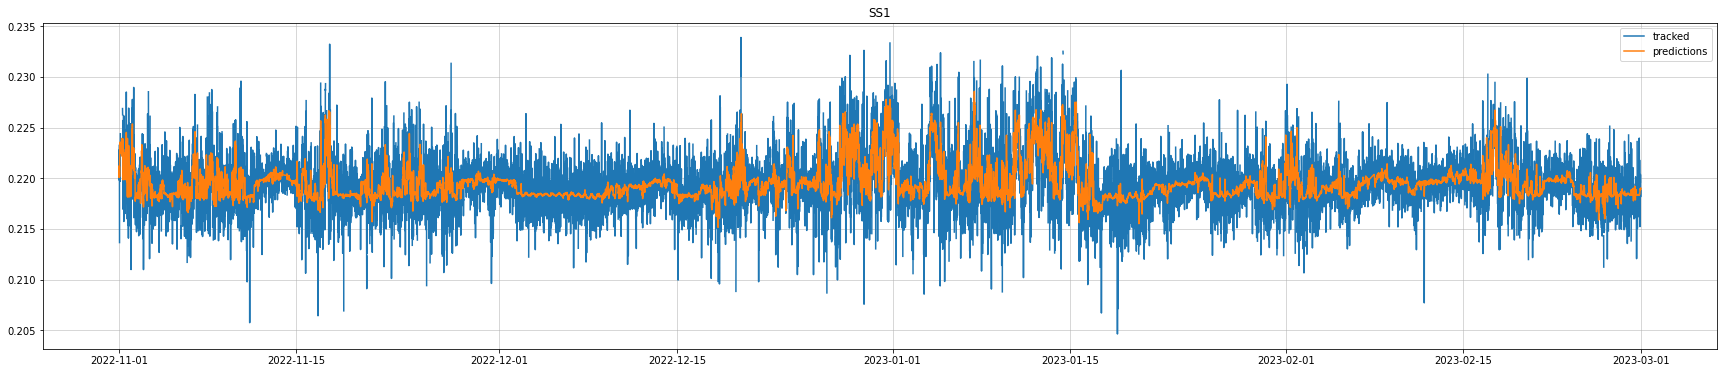

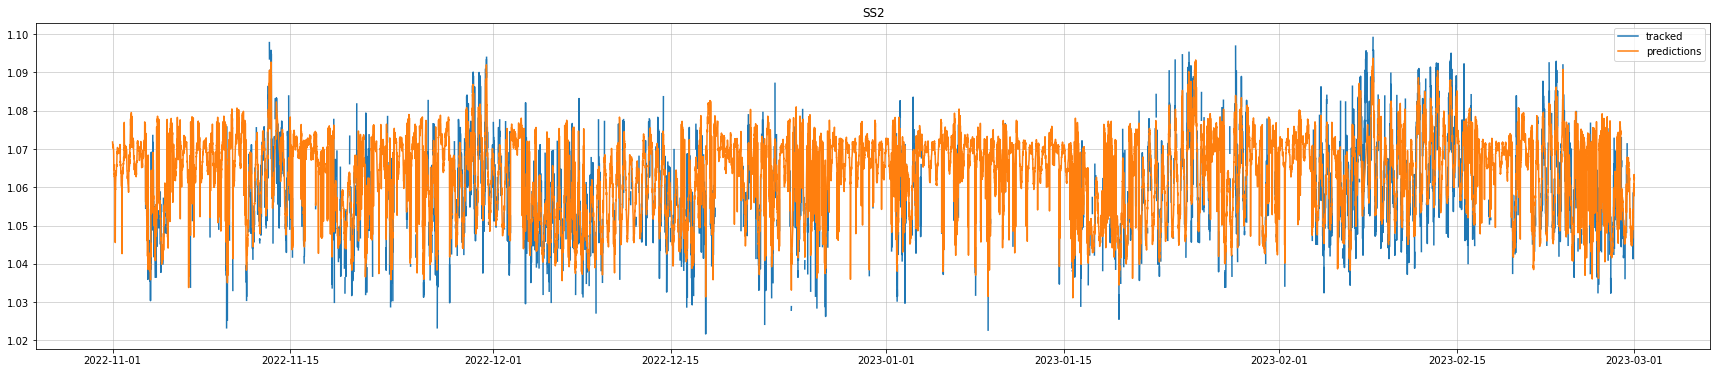

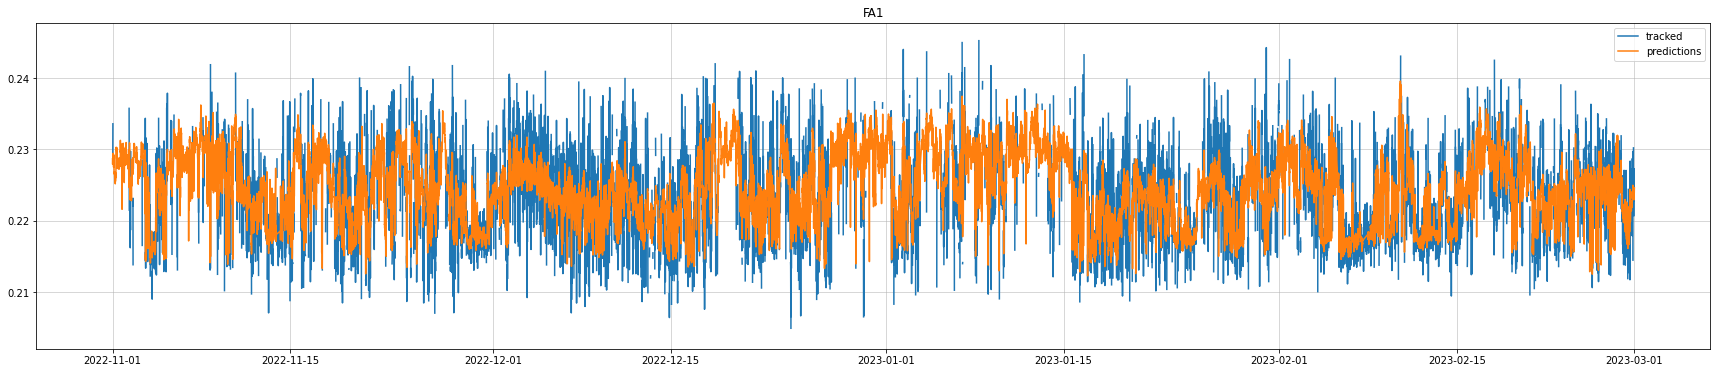

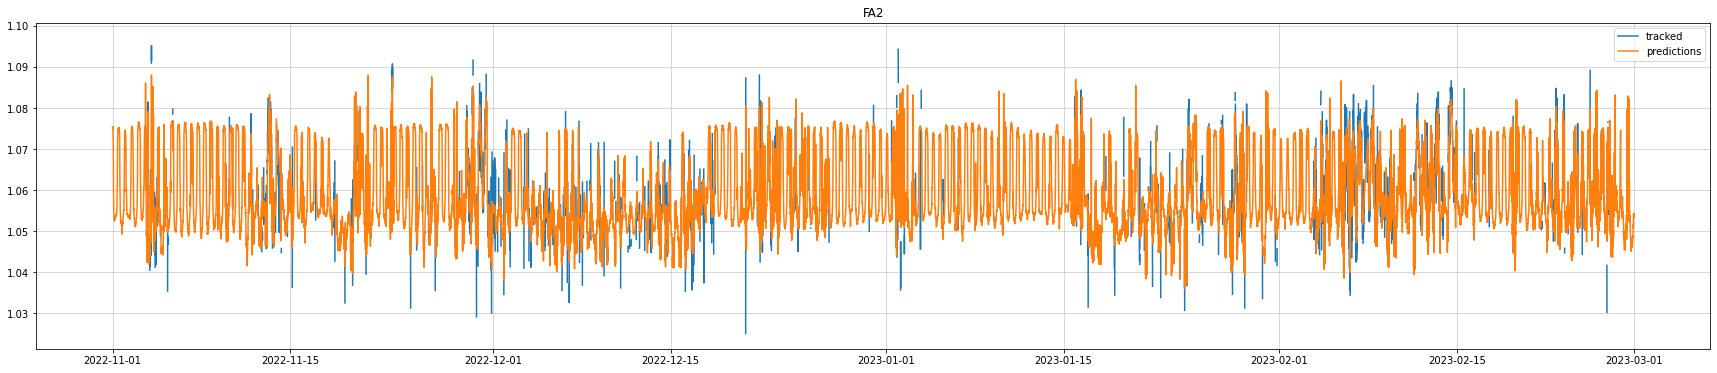

In [13]:
for mode in tracked_frequencies.columns:
    plt.figure(figsize=(30,6))
    plt.grid('--', linewidth=0.5)
    plt.title(mode)
    plt.plot(tracked_frequencies[mode], label = 'tracked')
    plt.plot(predictions[mode], label = 'predictions')
    plt.legend()
    plt.show()

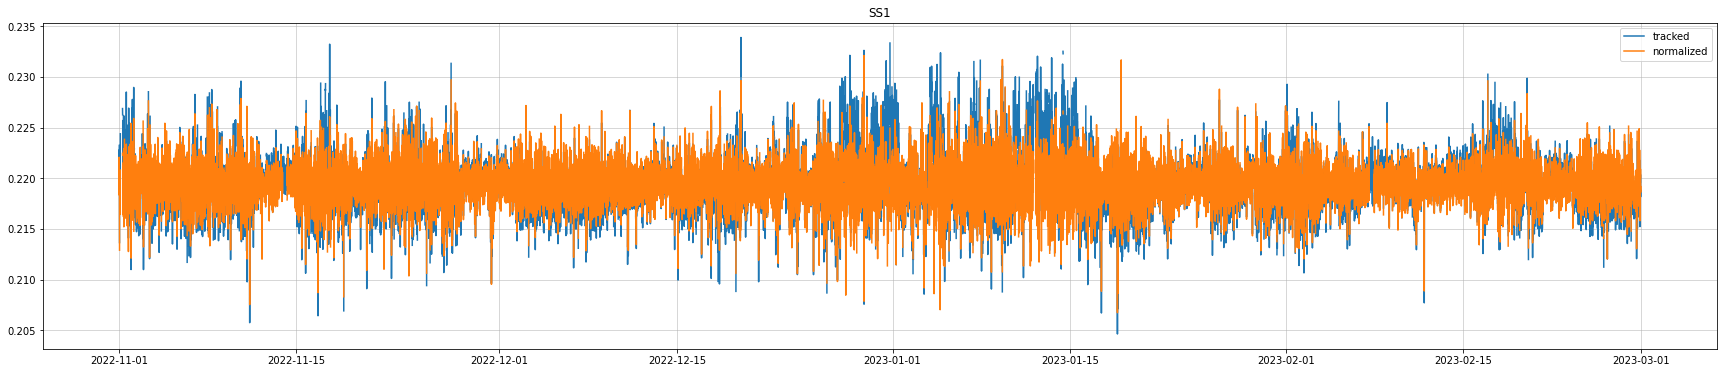

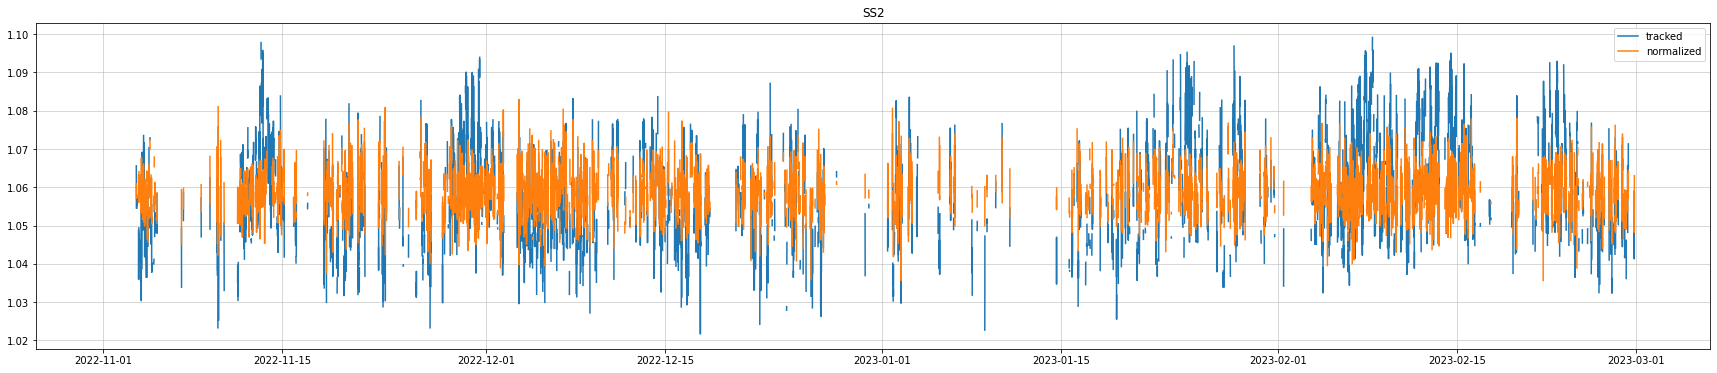

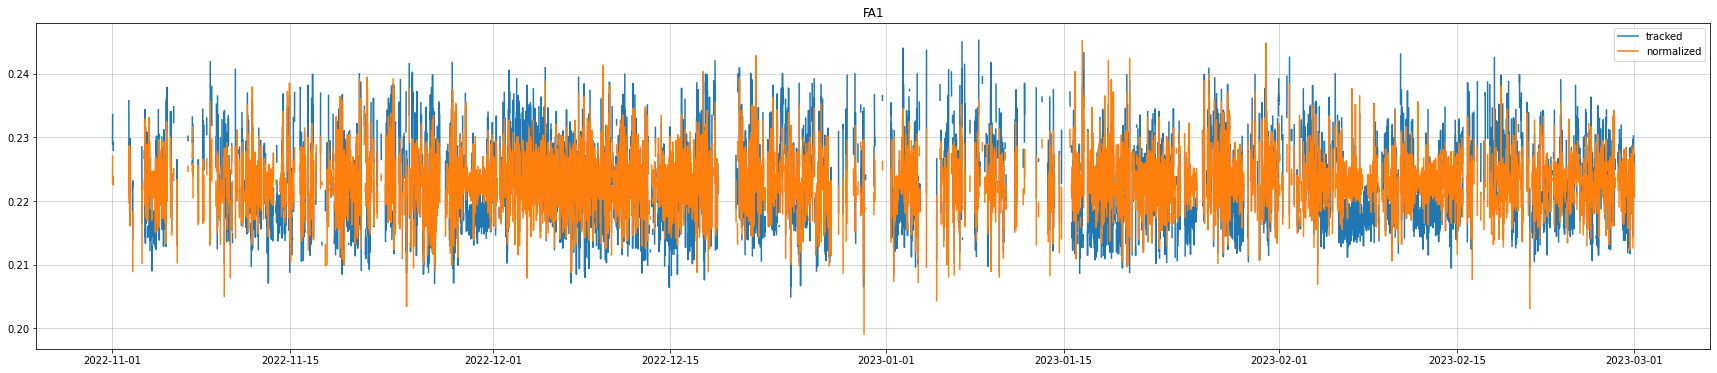

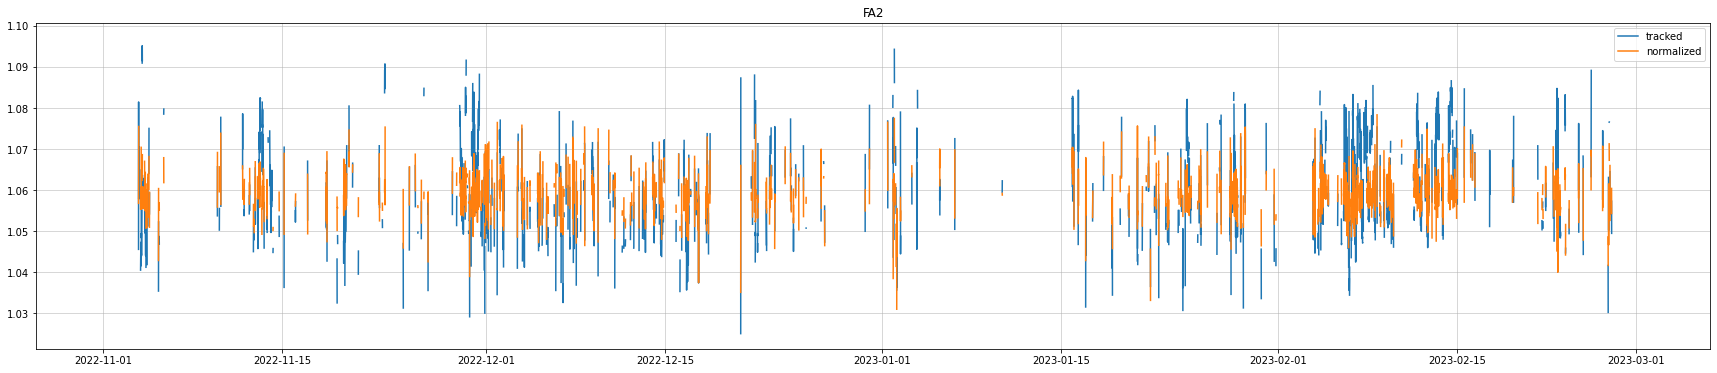

In [15]:
for mode in tracked_frequencies.columns:
    plt.figure(figsize=(30,6))
    plt.grid('--', linewidth=0.5)
    plt.title(mode)
    plt.plot(tracked_frequencies[mode], label = 'tracked')
    plt.plot(normalized[mode], label = 'normalized')
    plt.legend()
    plt.show()

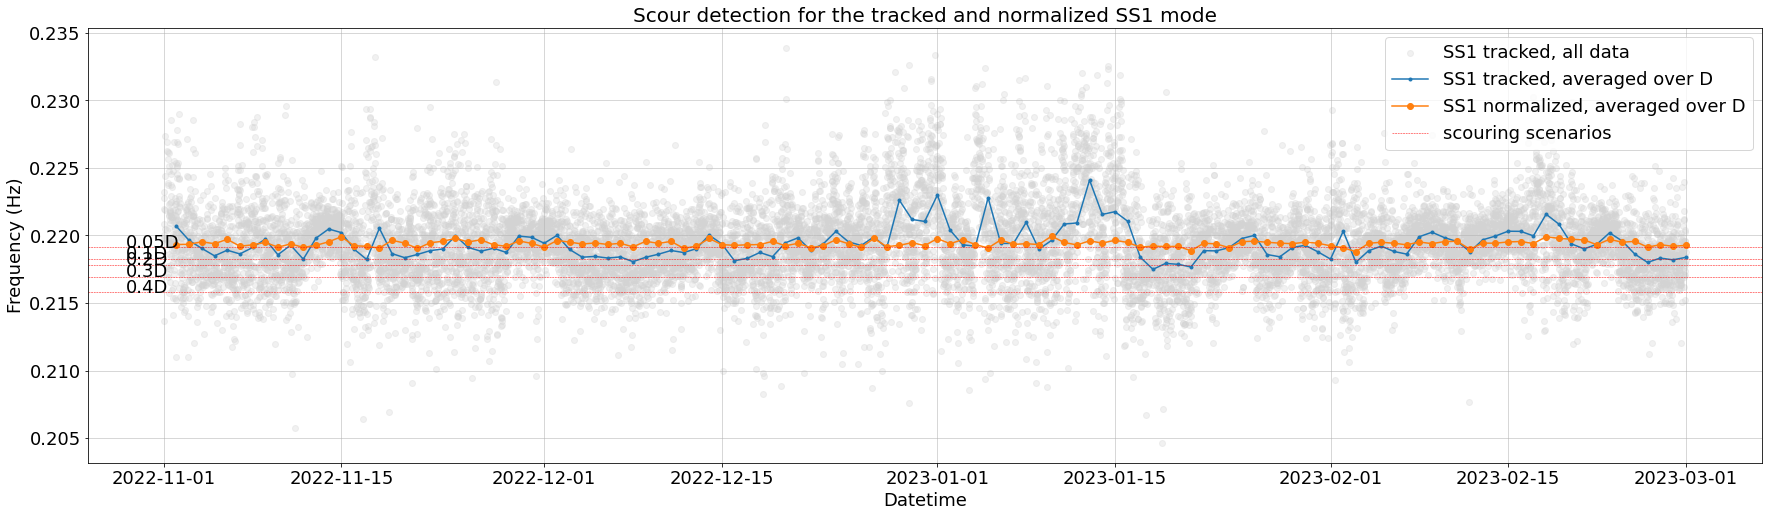

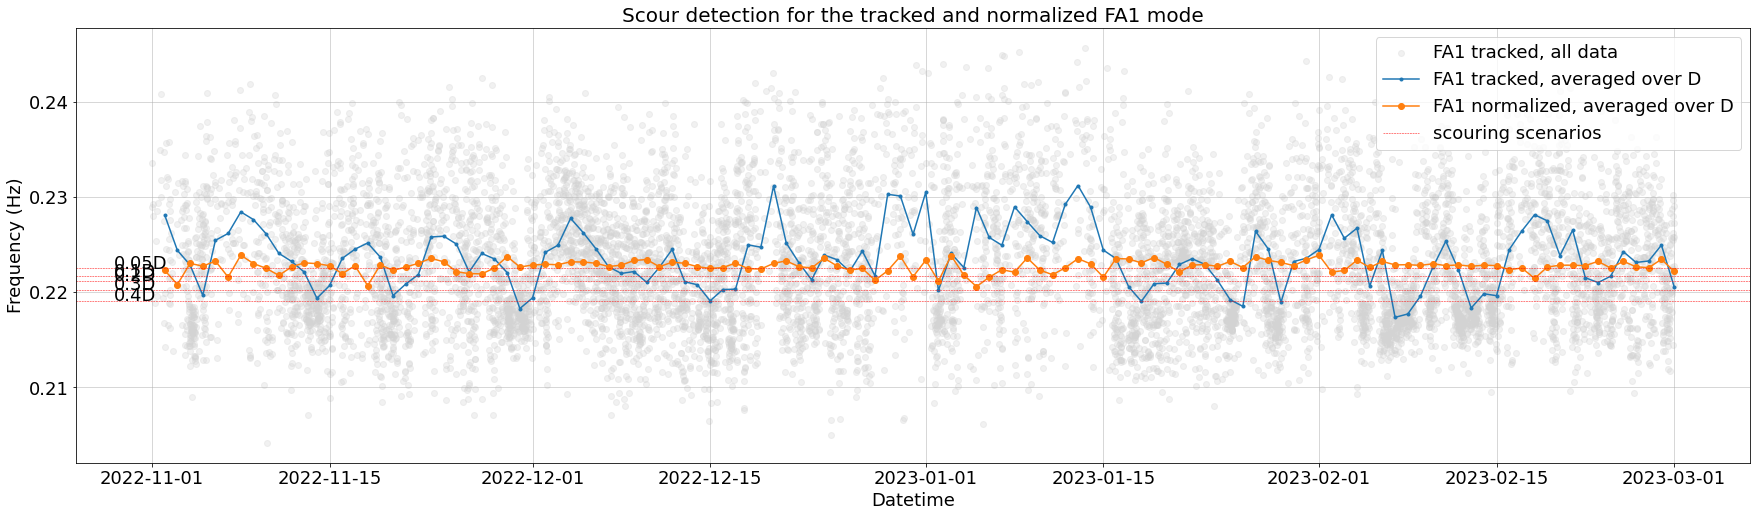

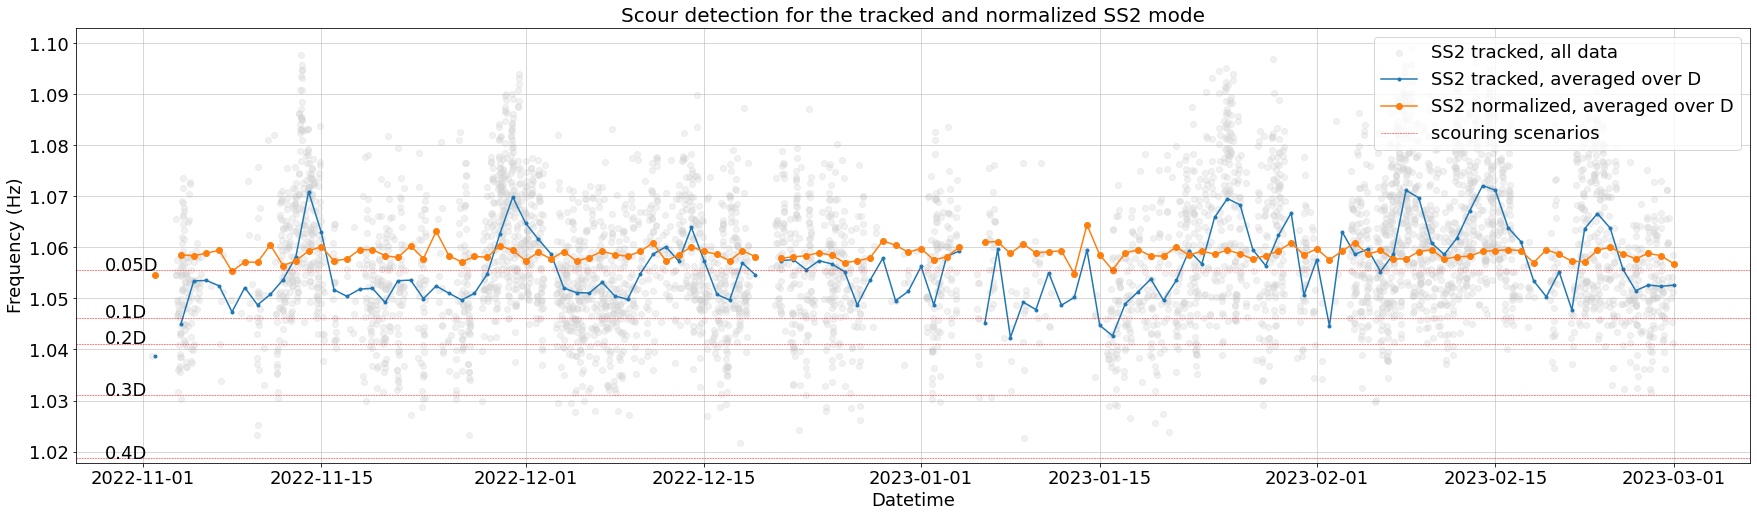

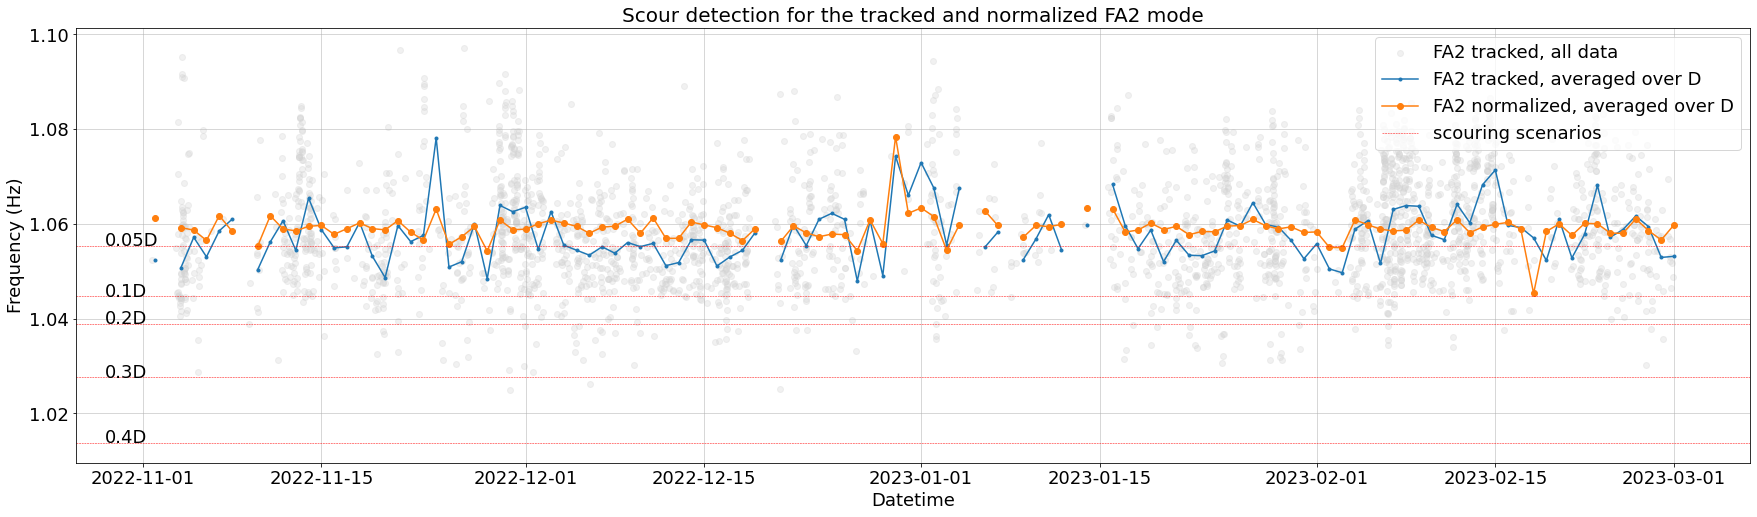

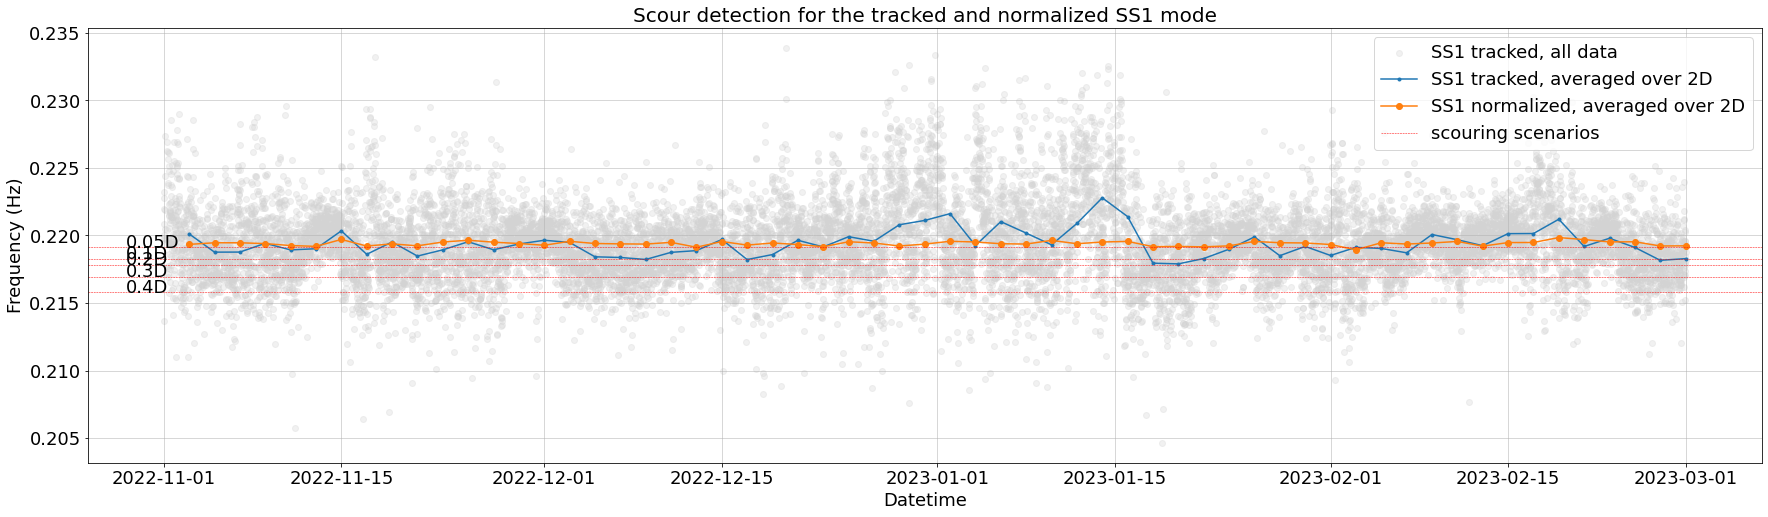

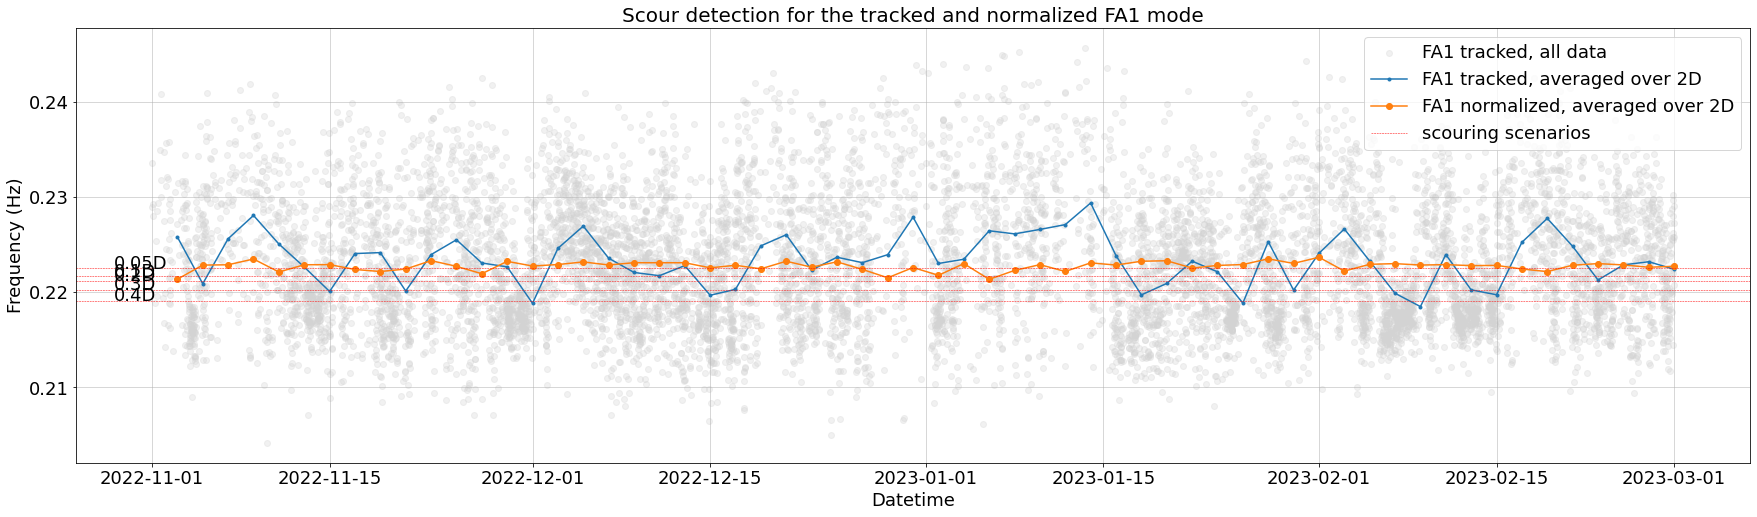

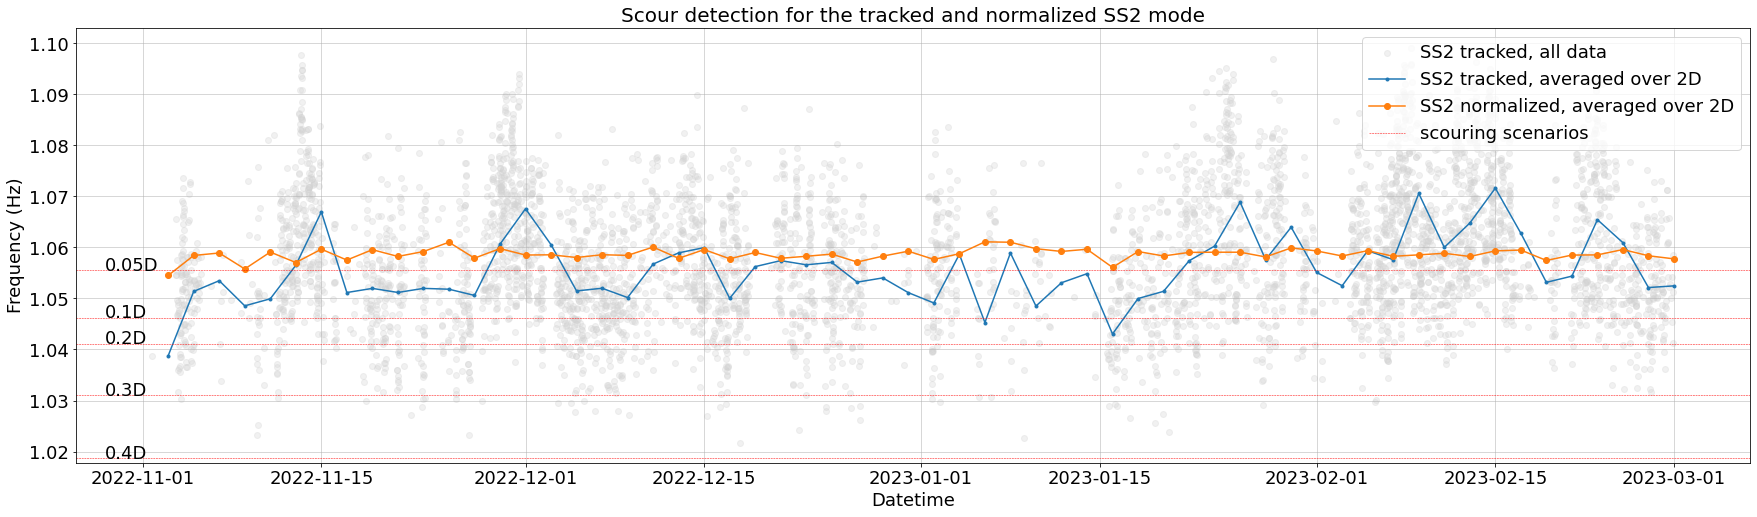

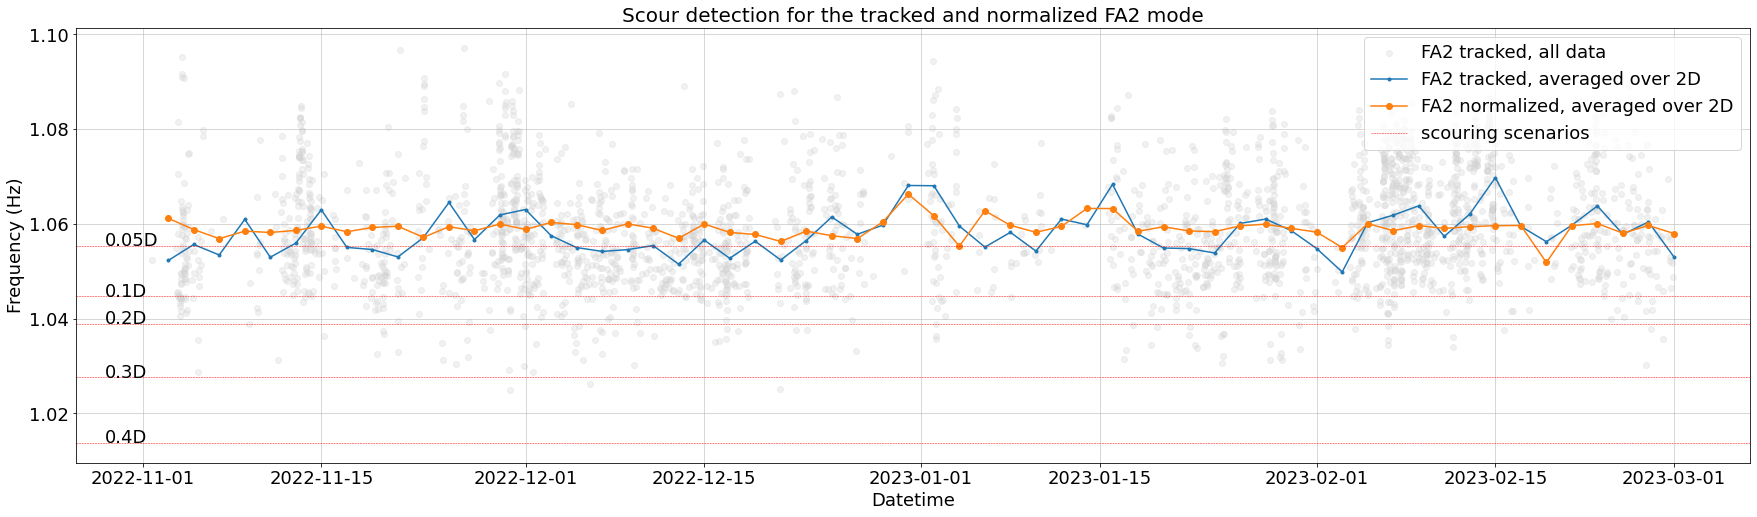

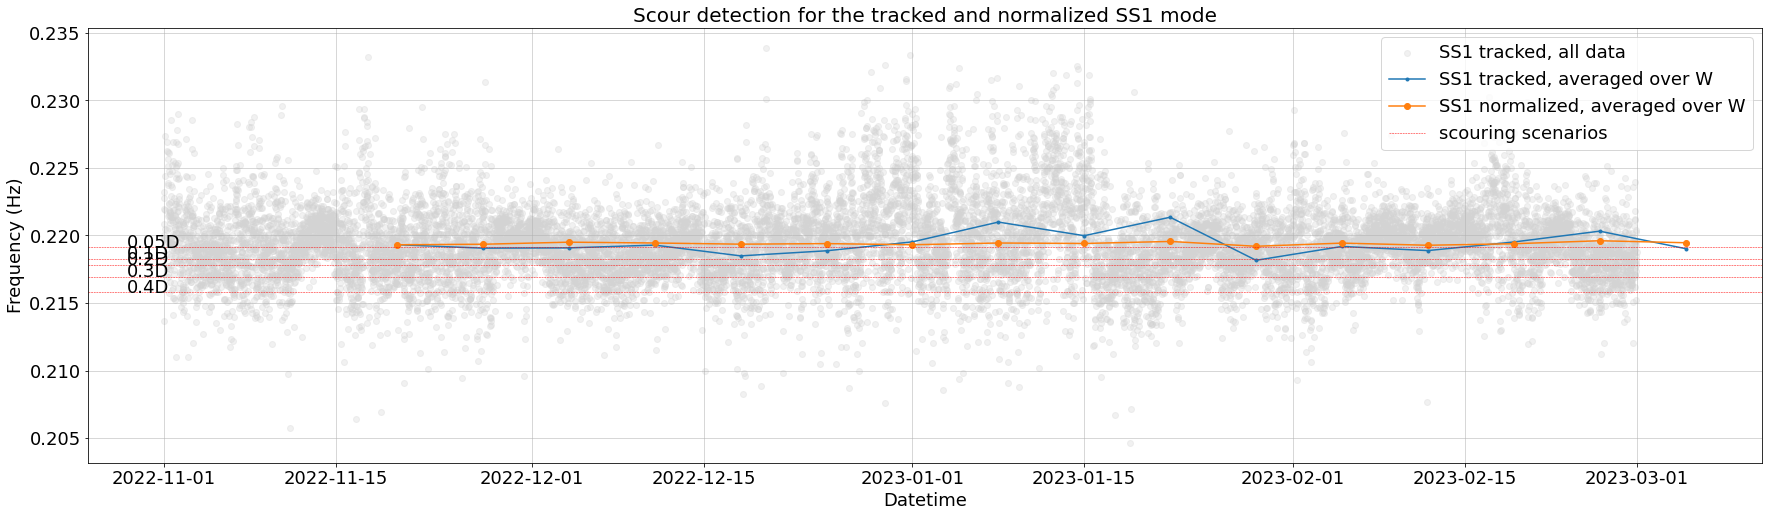

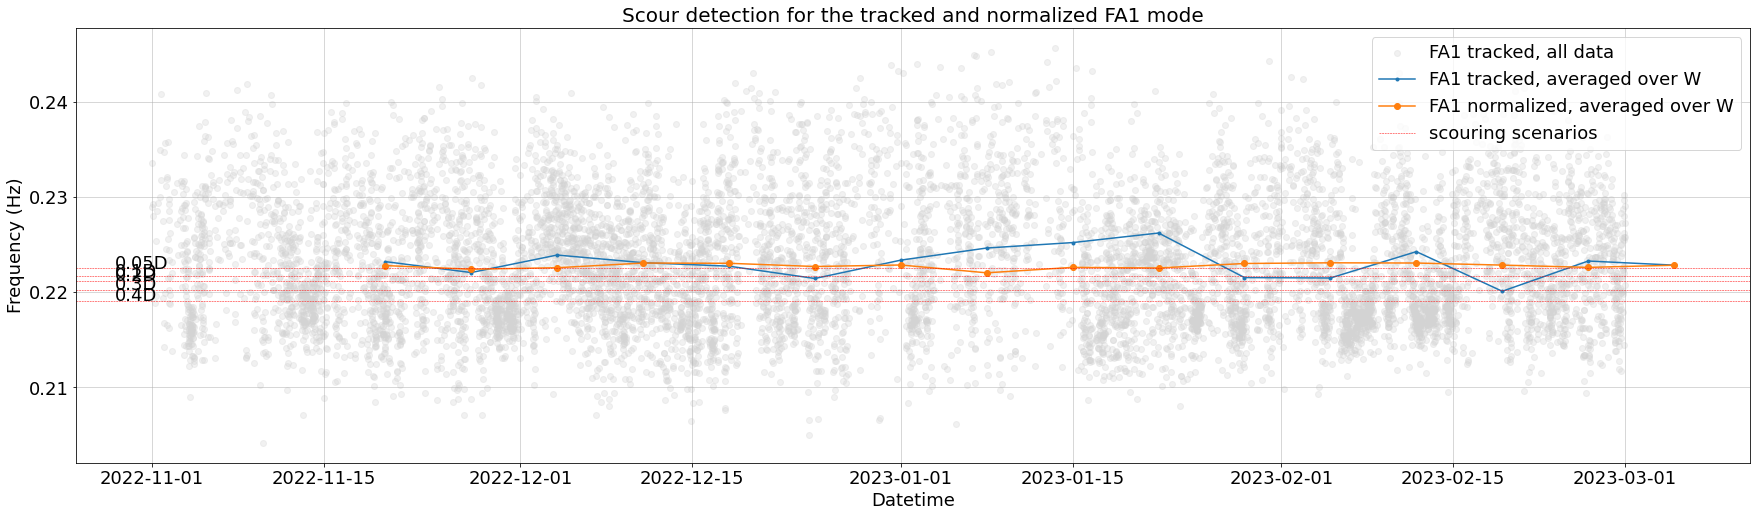

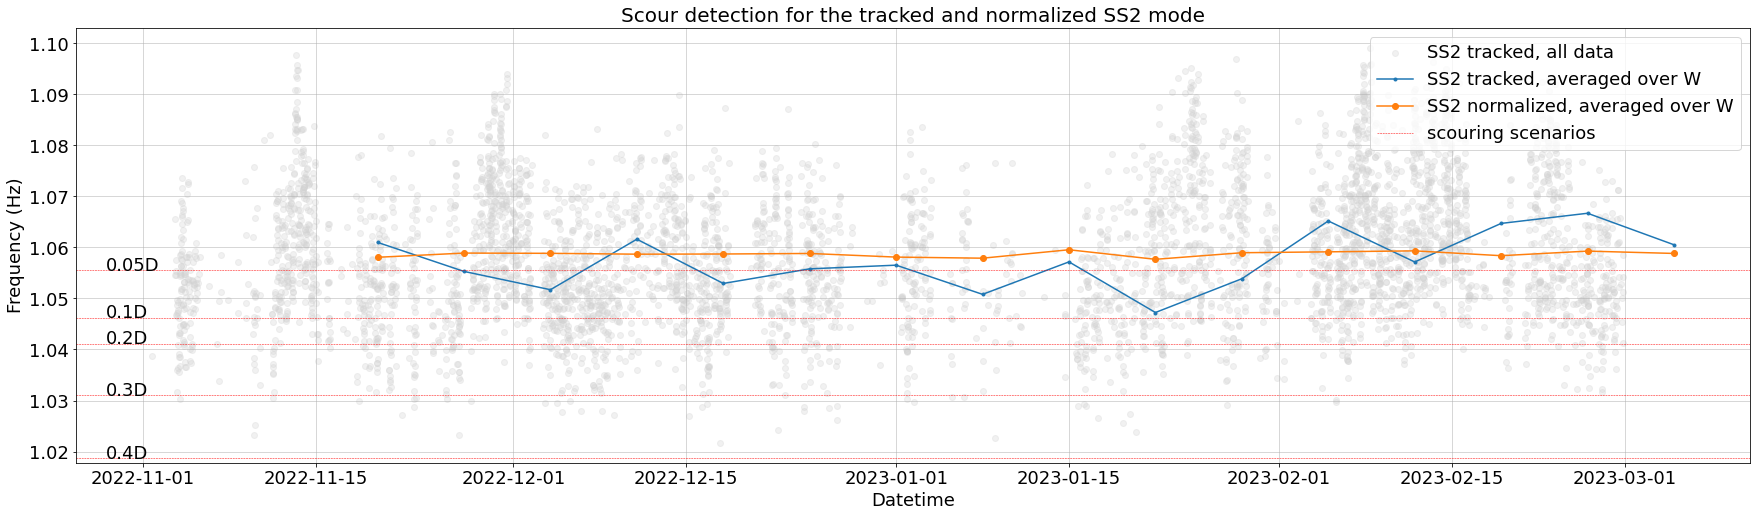

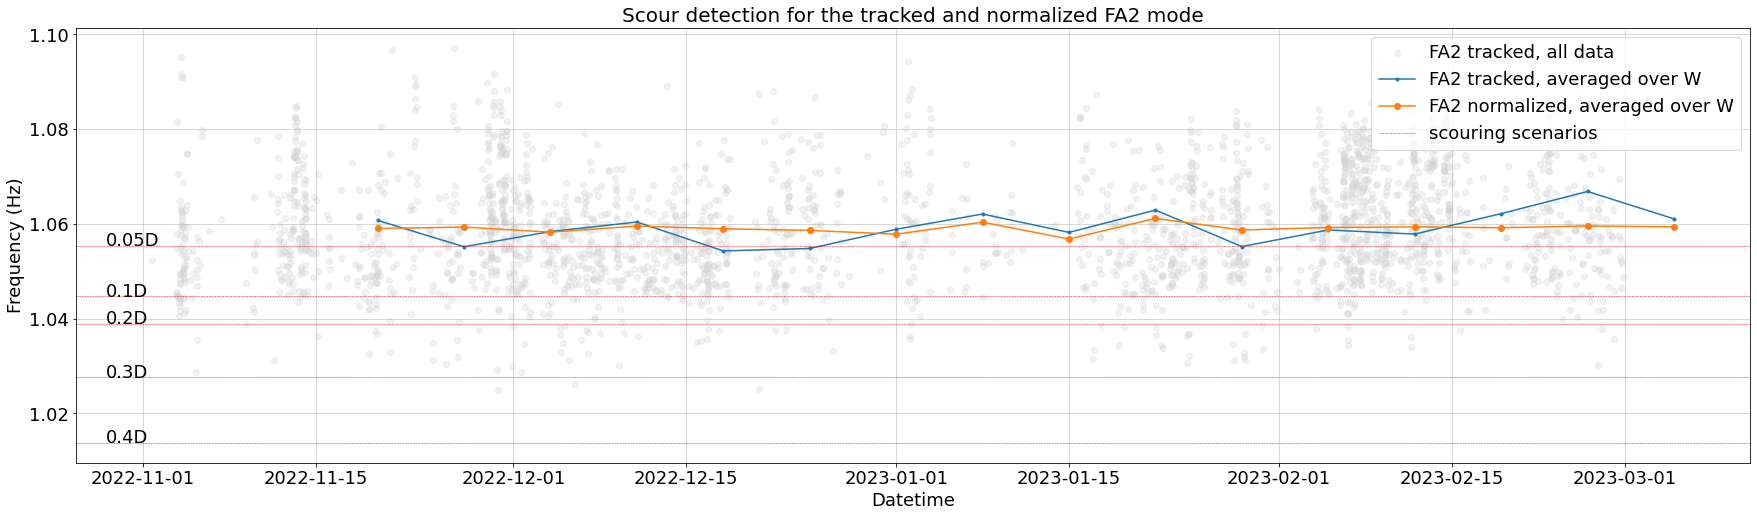

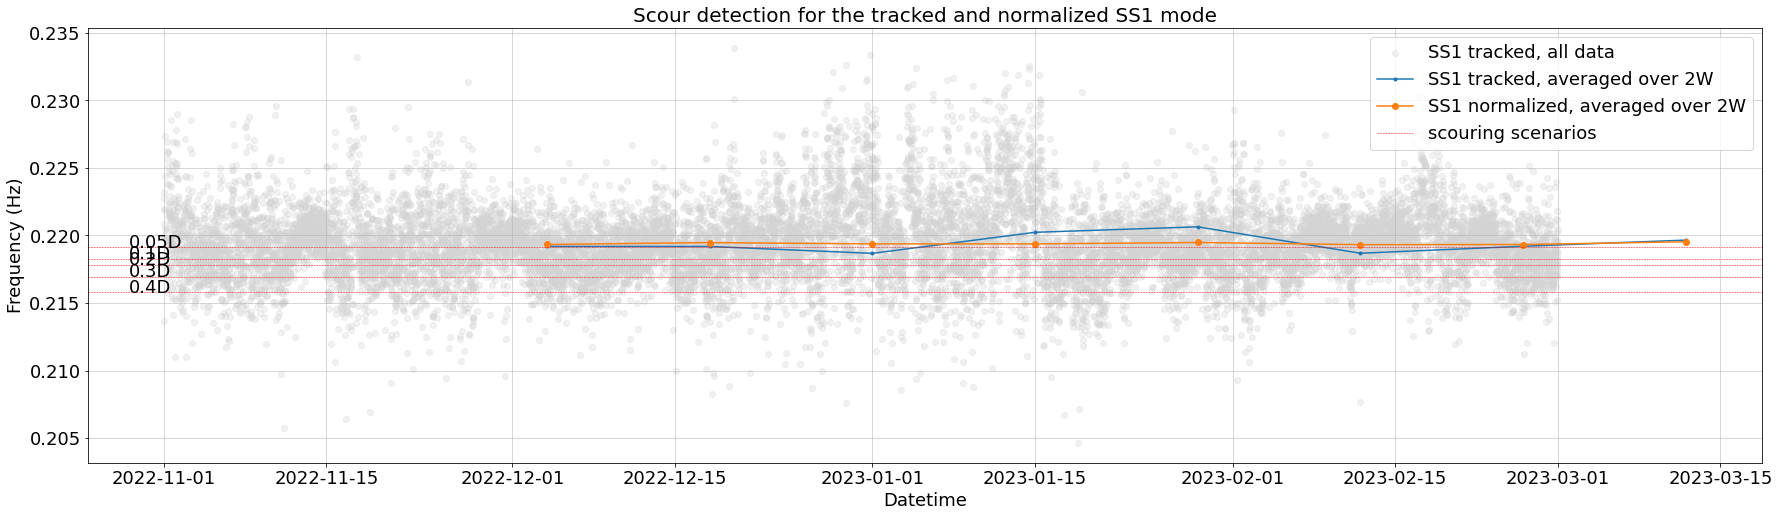

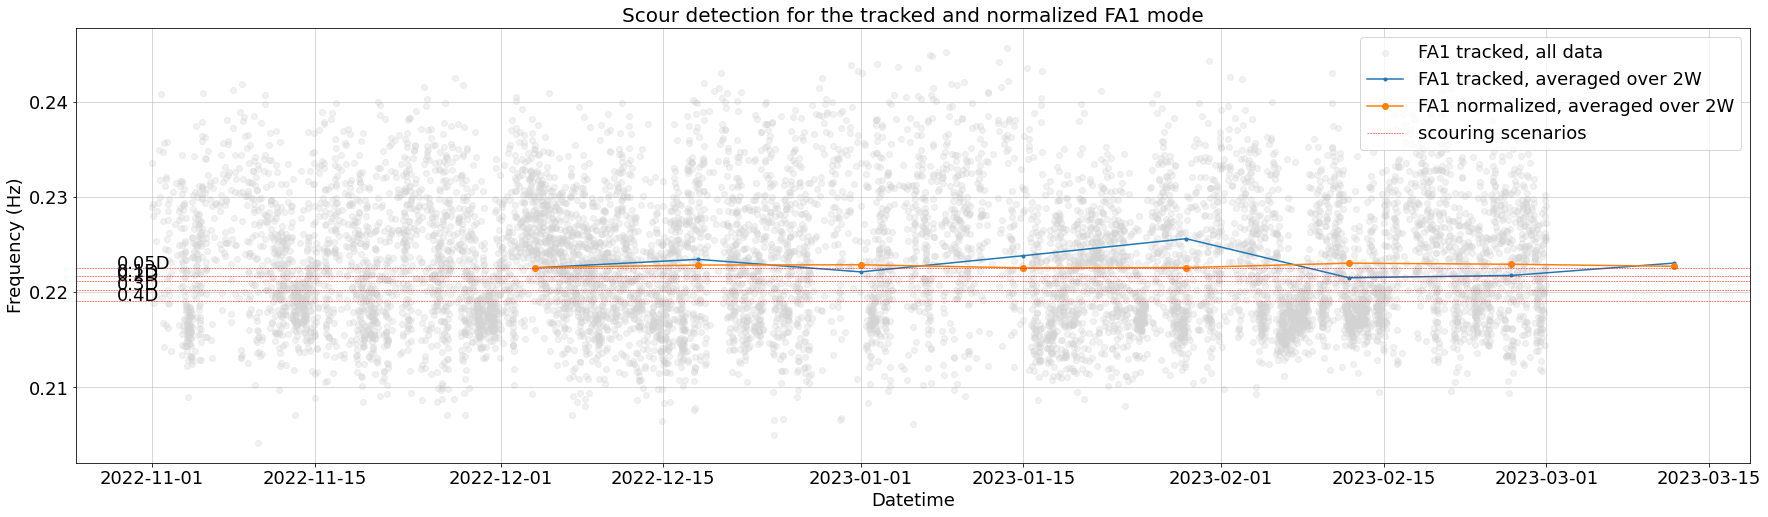

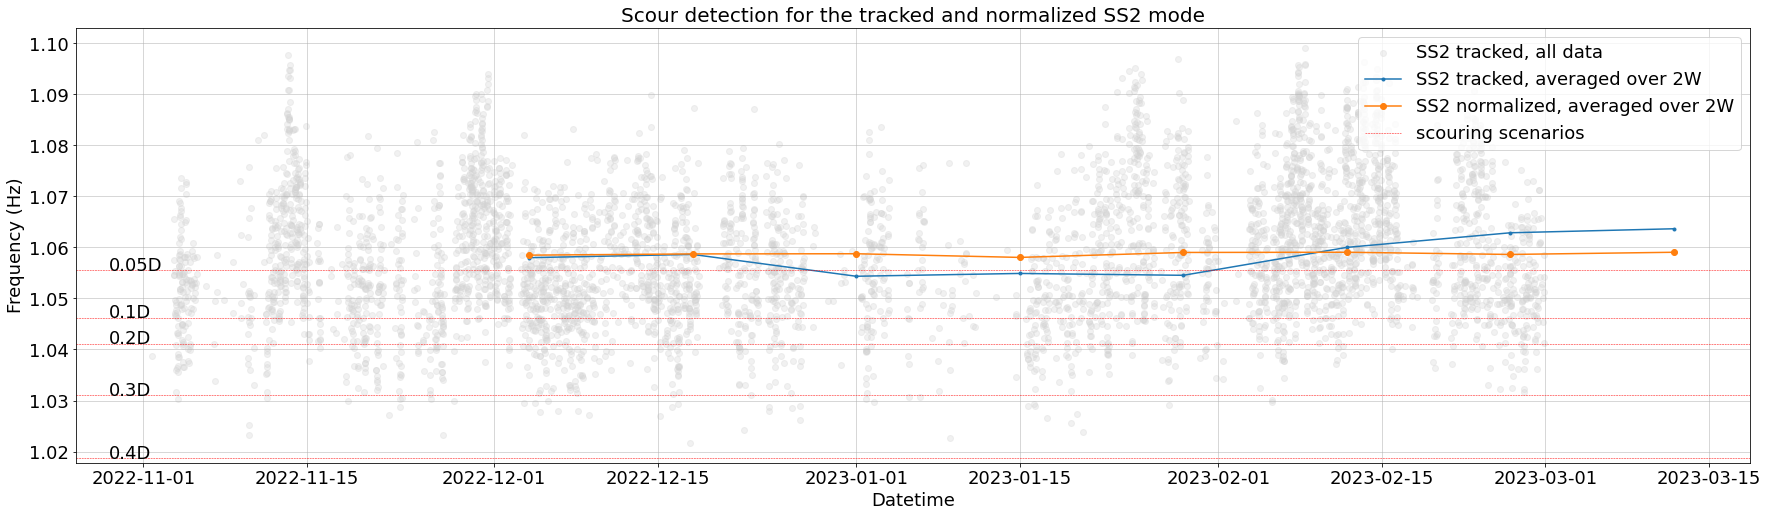

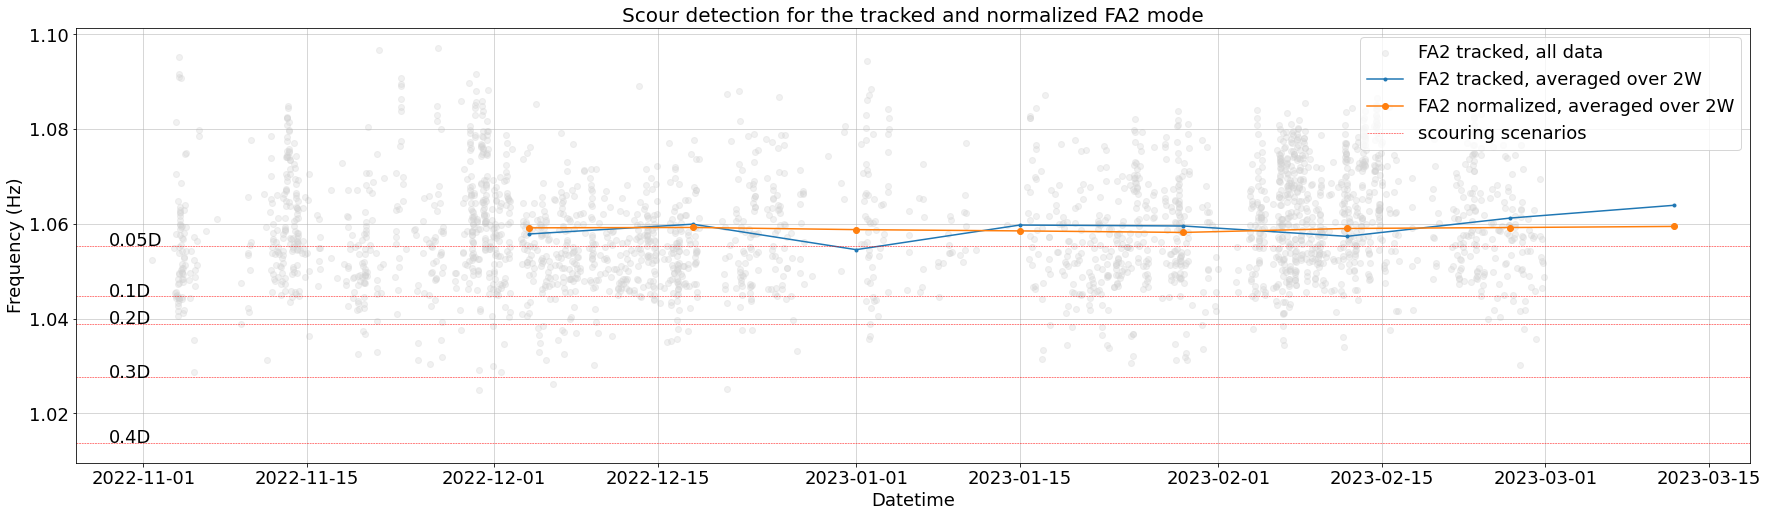

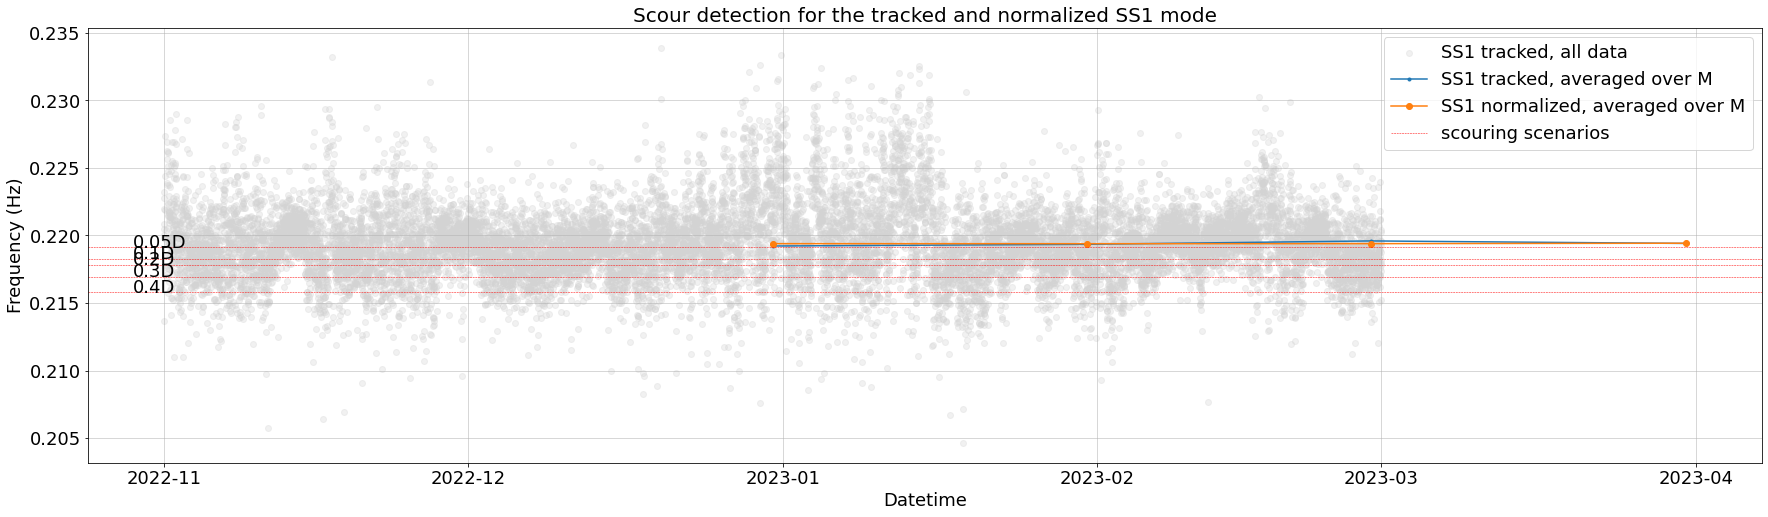

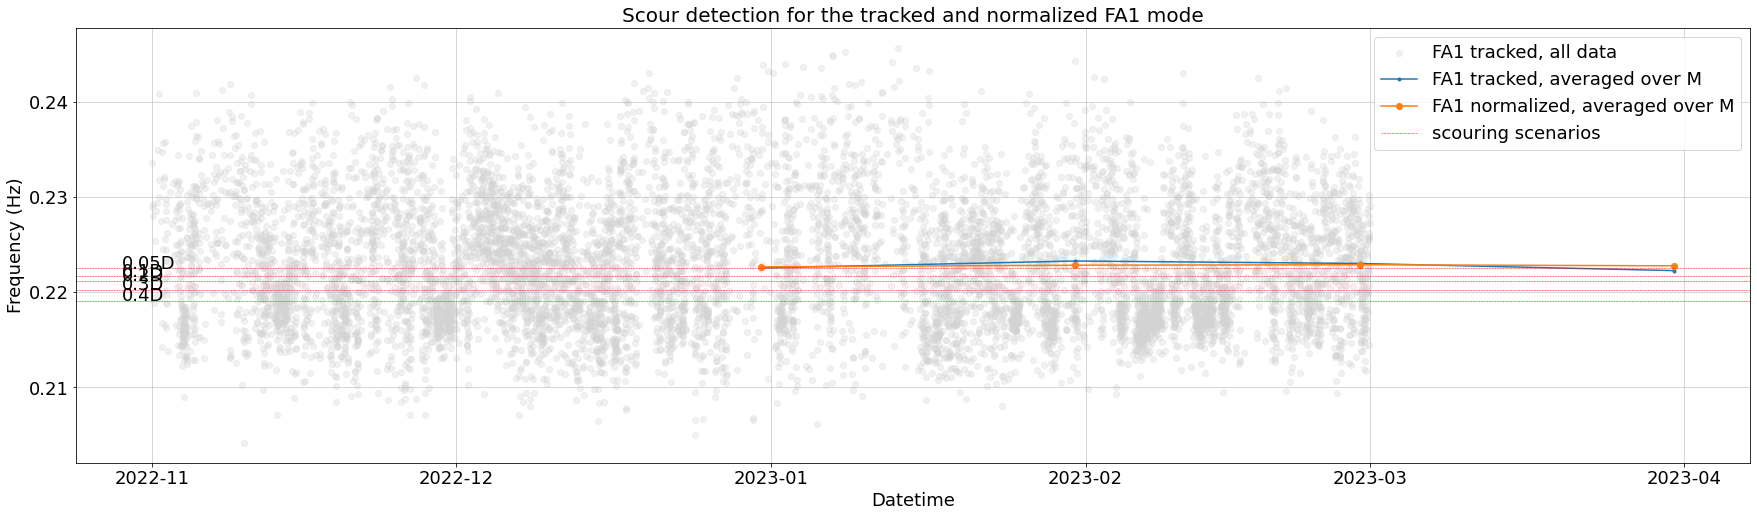

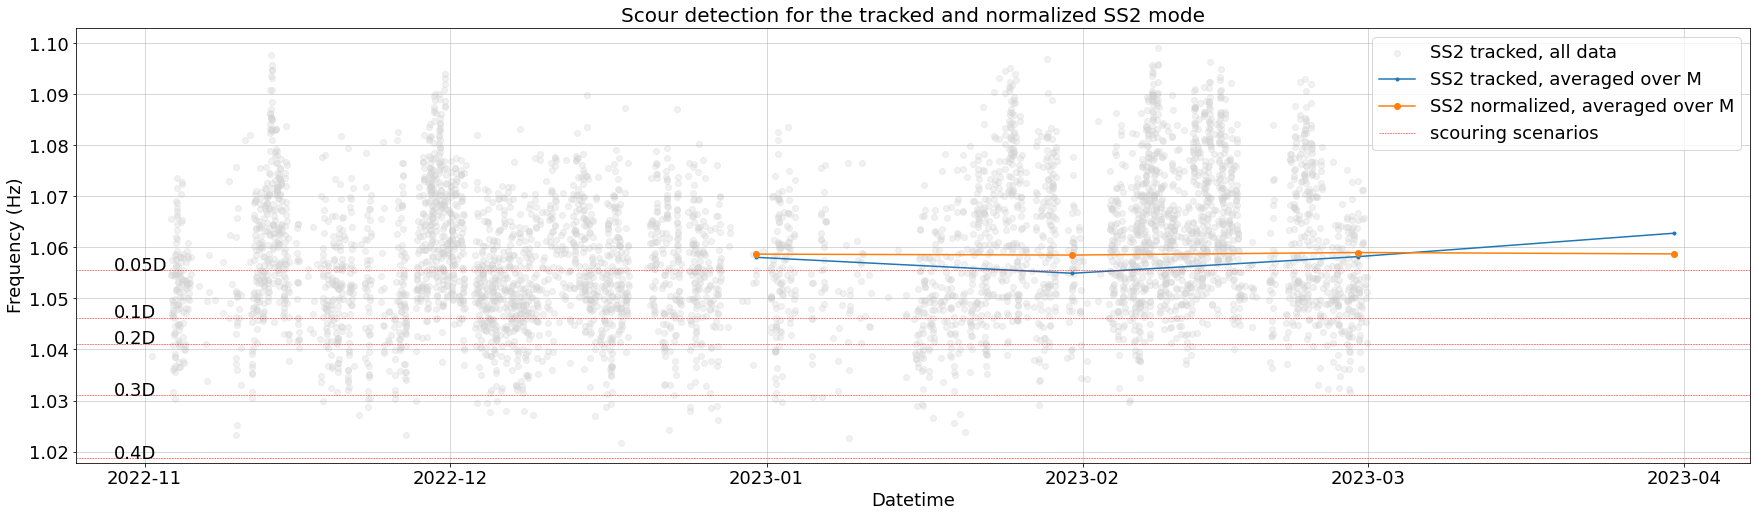

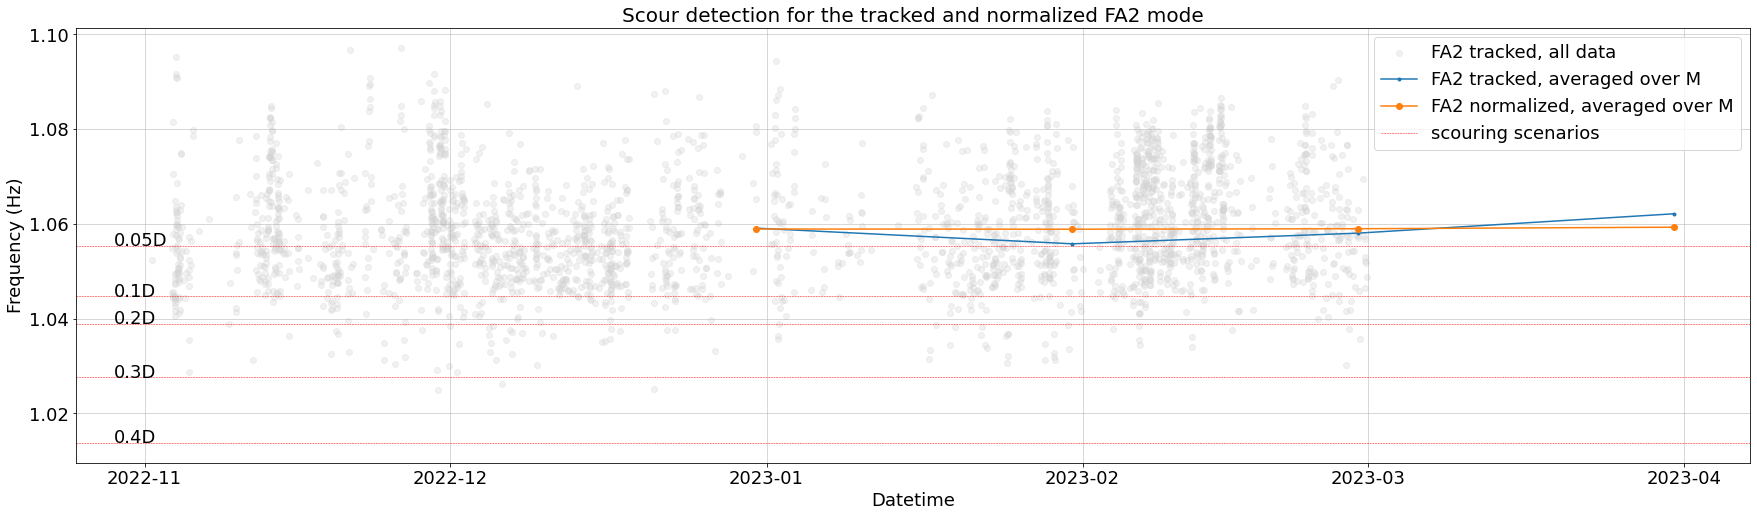

In [16]:
import warnings
warnings.filterwarnings('ignore')
font_size = 18
markers = ['.', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_']
timespans = ['D', '2D', 'W', '2W', 'M']
for timespan in timespans:
    for mode in ['SS1', 'FA1', 'SS2', 'FA2']:
        plt.figure(figsize=(30,8))
        plt.grid('--', linewidth=0.5)
        plt.title('Scour detection for the tracked and normalized ' + mode + ' mode', fontsize = 20)
        m = 0
        i = 0
        
        timely_tracked_frequencies = aggregate_time_series(tracked_frequencies, timespan)
        timely_normalized_frequencies = aggregate_time_series(normalized, timespan)
        plt.scatter(tracked_frequencies[mode].index, tracked_frequencies[mode], color='lightgrey', label = mode + ' tracked, all data', alpha=0.3)
        plt.plot(timely_tracked_frequencies[mode], label = mode + ' tracked, averaged over ' + timespan, marker = markers[m])
        m += 1
        plt.plot(timely_normalized_frequencies[mode], label = mode + ' normalized, averaged over ' + timespan, marker = markers[m])
        label = 'scouring scenarios'
        for value in simulation_shifts['parked_scour'][mode].values[:5]:
            plt.axhline(normalized[mode].mean() - normalized[mode].mean()*value/100, color='red', linestyle='--', linewidth=0.5, label = label)
            plt.text(normalized[mode].index[0] - datetime.timedelta(days=3), normalized[mode].mean() - normalized[mode].mean()*value/100, simulation_shifts['parked_scour']['Unnamed: 0'].values[i], fontsize=font_size)
            i += 1
            label =None
        plt.xticks(fontsize=font_size)
        plt.yticks(fontsize=font_size)
        plt.xlabel('Datetime', fontsize=font_size)
        plt.ylabel('Frequency (Hz)', fontsize=font_size)
        plt.legend(fontsize=font_size, loc='upper right')
        plt.show()

0.21911474125954863
0.21828665542896894
0.21781916927219716
0.21691012531158613
0.21577803618351274


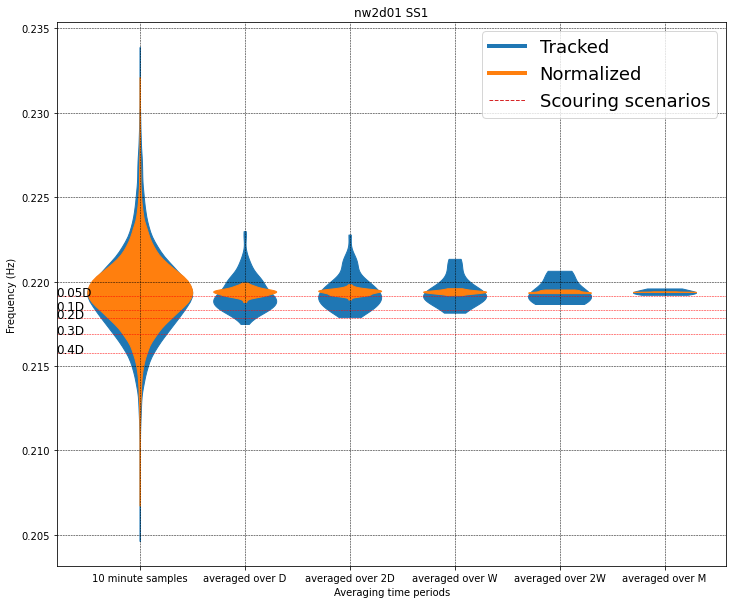

0.22249920667891196
0.22164660268524547
0.221165363759046
0.22022969842292953
0.21906469501319542


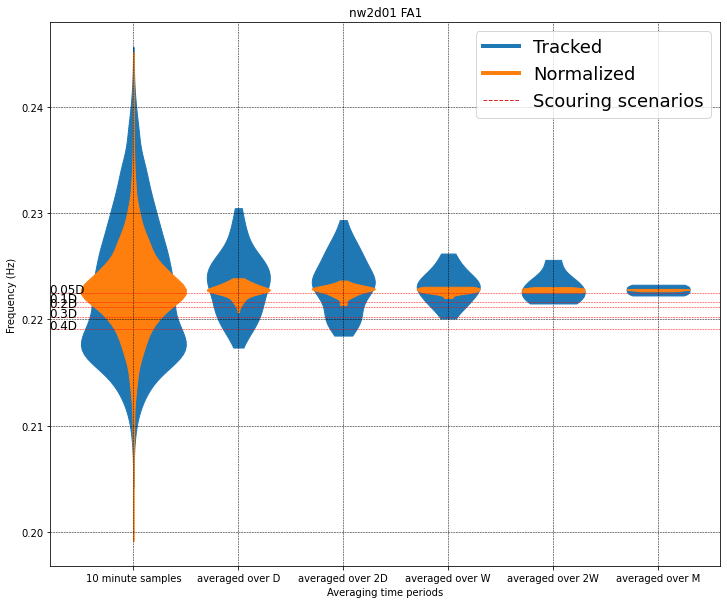

1.0554894873078704
1.0461860461869164
1.0410387575647881
1.0310361295622892
1.018687897227802


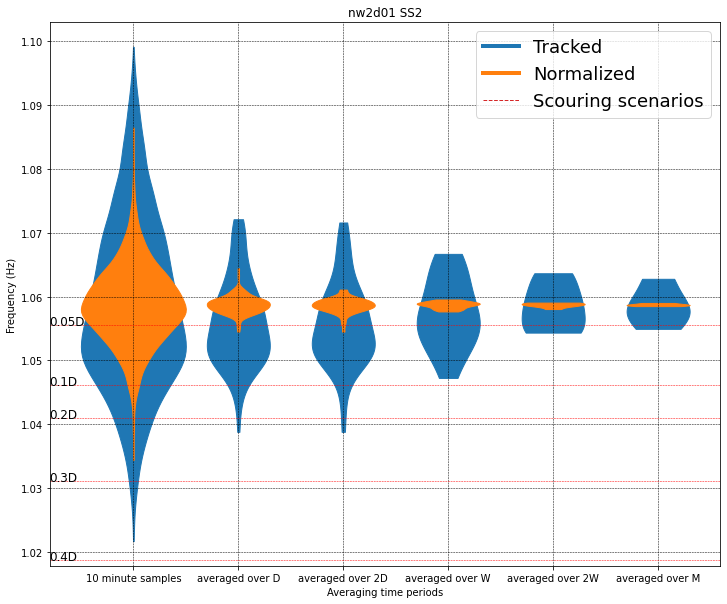

1.0553226815639867
1.044706050862608
1.0388666825301176
1.02757274466234
1.0137296016225184


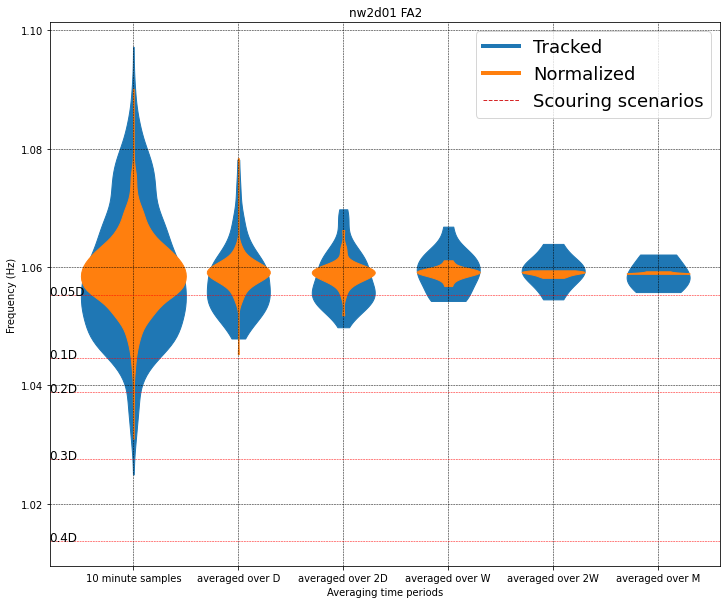

In [18]:
from matplotlib.lines import Line2D
font_size = 18
label = 'scouring scenarios'
timespans = ['D', '2D', 'W', '2W', 'M']
for mode in ['SS1', 'FA1', 'SS2', 'FA2']:
    fig, ax = plt.subplots(figsize=(12, 10))
    i = 1
    x_keys = []
    vps = plt.violinplot(tracked_frequencies[mode].dropna(), positions=[i], widths=1.0, showextrema=False)
    for vp in vps['bodies']:
        vp.set_facecolor('tab:blue')
        vp.set_color('tab:blue')
        vp.set_alpha(1)
    vps = plt.violinplot(normalized[mode].dropna(), positions=[i], widths=1.0, showextrema=False)
    for vp in vps['bodies']:
        vp.set_facecolor('tab:orange')
        vp.set_color('tab:orange')
        vp.set_alpha(1)
    
    x_keys.append('10 minute samples')
    i += 1
    for timespan in timespans:
        timely_tracked_frequencies = aggregate_time_series(tracked_frequencies, timespan).dropna()
        timely_normalized_frequencies = aggregate_time_series(normalized, timespan).dropna()
        vps = plt.violinplot(timely_tracked_frequencies[mode], positions=[i], widths=0.6, showextrema=False)
        for vp in vps['bodies']:
            vp.set_facecolor('tab:blue')
            vp.set_color('tab:blue')
            vp.set_alpha(1)
        vps = plt.violinplot(timely_normalized_frequencies[mode], positions=[i], widths=0.6, showextrema=False)
        for vp in vps['bodies']:
            vp.set_facecolor('tab:orange')
            vp.set_color('tab:orange')
            vp.set_alpha(1)
        x_keys.append('averaged over ' + timespan)
        i += 1
    j = 0
    for value in simulation_shifts['parked_scour'][mode].values[:5]:
        shift = normalized[mode].mean() - normalized[mode].mean()*value/100
        print(shift)
        plt.axhline(shift, color='red', linestyle='--', linewidth=0.5, label = label)
        plt.text(
            0.2,
            shift,
            simulation_shifts['parked_scour']['Unnamed: 0'].values[j],
            fontsize=12
            )
        j += 1
    ax.set_xticks(range(1, len(x_keys) + 1))
    ax.set_xticklabels(x_keys, rotation=0)
    ax.set_title(location + ' ' + mode)
    ax.set_ylabel('Frequency (Hz)')
    ax.set_xlabel('Averaging time periods')
    ax.grid(True, color='k', linestyle='--', linewidth=0.5)
    plt.legend(
        [Line2D([0], [0], color='tab:blue', lw=4), Line2D([0], [0], color='tab:orange', lw=4), Line2D([0], [0], color='tab:red', lw=1, linestyle='--')],
        ['Tracked', 'Normalized', 'Scouring scenarios'],
        fontsize=font_size,
        loc='upper right')
    plt.show()